# Supervised Learning Capstone

## This is a dataset from LendingClub that looks at all loans issued through 2007 to 2011 including current loan status.

The goal is to see if we can correctly predict which loans are paid v. charged off based on variables in the dataset by using various supervised learning methods.

Link to dataset:https://www.lendingclub.com/info/download-data.action

__Question I am trying to answer: Can we correctly predict loans that will be paid v. charged off based on various variables?__

__The main target variables I was looking at were Fully Paid and Charged Off. Fully Paid = 1, Charged Off = 0.__

To answer this question, I have used various supervised learning methods such as Naive Bayes, Logistic Regression with Grid Search, Random Forest Classifier with Grid Search, KNN Neighbors with Grid Search and an attempted SVM model which did not work.

Accuracy scores with each model:

- Naive Bayes: 0.8574
- Random Forest: 0.8752
- Logistic Regression: 0.8601
- KNN: 0.8609

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## __Understanding the dataset and evaluating the data types.__

My first step was understanding the dataset and evaluating various datatypes. To do so, I looked at various aspects of the dataset such as rows / columns, shape, data types.

I also calcuated the benchmark score for two target variables I was looking at Fully Paid v. Charged Off.

- Fully Paid = 34116
- Charged Off = 5670
- Fully Paid Benchmark Percentage: 86%
- Charged Off Benchmark Percentage: 14%

In [2]:
df = pd.read_csv("loan.csv", low_memory = False)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

In [5]:
df.dtypes

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [6]:
df['loan_status'].head()

0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
4     Fully Paid
Name: loan_status, dtype: object

In [7]:
df['loan_status'].value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [8]:
print("Shape of Dataset: ", df.shape)

Shape of Dataset:  (42542, 150)


In [9]:
# Benchmark score 

fully_paid = 34116 
charged_off = 5670 
total = 34116 + 5670
print(total)
benchmark = charged_off/ total
print(benchmark)
benchmark_paid = fully_paid / total
print(benchmark_paid)

39786
0.14251244156235862
0.8574875584376414


## __Data cleaning and Transforming:__

Cleaning up the data and transforming them to get them ready for analysis.

- Changed "Fully Paid" to 1 making it numeric
- Changed "Charged Off" to 0 making it numeric
- Dropped rows if it doesn't have at least 35,000 values
- NaNs were then replaced with zeros
- Changed loan grades to be numeric in order (A = 7 (highest)....G = 1 (lowest))
- Removed special characters from columns avoiding errors created by special characters altogether
- Changed home ownership to numeric values in ranks (Mortgage = 5 (highest).... None = 1 (lowest))
- Converted column values to floats or integers

In [10]:
df_loanstatus = df[(df['loan_status']== 'Fully Paid') | (df['loan_status'] == 'Charged Off')]
bl = {'Fully Paid': 1, 'Charged Off' : 0}
df_final = df_loanstatus.replace({'loan_status': bl})

In [11]:
#Fully Paid is now 1 and Charged Off is 0 
# bl above is boolean 
df_final['loan_status'].head()

0    1
1    0
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [12]:
df_final['loan_status'].value_counts()

1    34116
0     5670
Name: loan_status, dtype: int64

In [13]:
#Drops row if it does not have at least 35,000 values that are not NAN 
df_final = df_final.dropna(thresh = 35000, axis = 1)

In [14]:
print('Shape:', df_final.shape)

Shape: (39786, 58)


In [15]:
df_final['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [16]:
# A , B , C , D, E, F, G (A is the best and G is the worst)
# A = 7, B = 6, C = 5, D = 4, E = 3, F = 2 , G = 1

df_final['grade'] = df_final['grade'].map({'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1})

In [17]:
df_final['grade'].unique()

array([6, 5, 7, 3, 2, 4, 1], dtype=int64)

In [18]:
df_final['emp_length'] = df['emp_length'].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a': 0, 'NaN' : 0, 'nan': 0}, regex = True)

In [19]:
df_final['emp_length'].head()

0    10
1     1
2    10
3    10
4     1
Name: emp_length, dtype: object

In [20]:
df_final['emp_length'].dropna(how = all)

0        10
1         1
2        10
3        10
4         1
5         3
6         8
7         9
8         4
9         1
10        5
11       10
12        1
13        3
14        3
15        1
16        4
17       10
18        1
19        6
20        3
21       10
22       10
23        5
24        1
25        2
26        9
27        2
28       10
29        1
         ..
39756     9
39757     6
39758     1
39759     3
39760     1
39761     1
39762     1
39763     8
39764     7
39765     2
39766     1
39767     1
39768     4
39769     1
39770     7
39771     1
39772     2
39773     1
39774     8
39775     1
39776     2
39777     4
39778     1
39779     1
39780     5
39781     4
39782     3
39783     1
39784     1
39785     1
Name: emp_length, Length: 38708, dtype: object

In [21]:
df_final['term'] = df['term'].replace({'months': '', 'month': '', 'n/a': '0', 'nan': 0}, regex = True)

In [22]:
df_final['term'].head()

0     36 
1     60 
2     36 
3     36 
4     60 
Name: term, dtype: object

In [23]:
df_final['term'].value_counts()

 36     29096
 60     10690
Name: term, dtype: int64

In [24]:
df_final['term'] = df_final['term'].apply(lambda x: int(x))

In [25]:
df_final['term'].describe()

count    39786.000000
mean        42.448499
std         10.638782
min         36.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: term, dtype: float64

In [26]:
df_final['emp_length'].head()

0    10
1     1
2    10
3    10
4     1
Name: emp_length, dtype: object

In [27]:
df_final = df_final.dropna(axis = 1, how = 'all')

In [28]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            'last_pymnt_amnt', 'loan_amnt', 'int_rate', 'open_acc',
            'loan_status'] 
df_final = df_final[features]

In [29]:
df_final['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'], dtype=object)

In [30]:
# Home Ownership is (Highest to Lowest in a way): Mortgage, Rent, Own, Other, None 
# Mortgage = 5 , Rent = 4, Own = 3, Other = 2, None = 1
df_final['home_ownership'] = df_final['home_ownership'].map({'MORTGAGE': 5, 'RENT': 4, 'OWN': 3, 'OTHER': 2, 'NONE': 1})

In [31]:
df_final.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,loan_amnt,int_rate,open_acc,loan_status
0,5000.0,10,24000.0,4,6,171.62,5000.0,10.65%,3.0,1
1,2500.0,1,30000.0,4,5,119.66,2500.0,15.27%,3.0,0
2,2400.0,10,12252.0,4,5,649.91,2400.0,15.96%,2.0,1
3,10000.0,10,49200.0,4,5,357.48,10000.0,13.49%,10.0,1
4,3000.0,1,80000.0,4,6,67.30,3000.0,12.69%,15.0,1


In [32]:
df_final = df_final.fillna(0)

In [33]:
df_final['emp_length'] = df_final['emp_length'].apply(lambda x: int(x))

In [34]:
df_final['emp_length'].describe()

count    39786.000000
mean         4.954934
std          3.462426
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64

In [35]:
df_final.dtypes

funded_amnt        float64
emp_length           int64
annual_inc         float64
home_ownership       int64
grade                int64
last_pymnt_amnt    float64
loan_amnt          float64
int_rate            object
open_acc           float64
loan_status          int64
dtype: object

In [36]:
df_final['funded_amnt'] = df_final['funded_amnt'].apply(lambda x: int(x))

In [37]:
df_final.dtypes

funded_amnt          int64
emp_length           int64
annual_inc         float64
home_ownership       int64
grade                int64
last_pymnt_amnt    float64
loan_amnt          float64
int_rate            object
open_acc           float64
loan_status          int64
dtype: object

In [38]:
df_final['loan_amnt'] = df_final['loan_amnt'].apply(lambda x: int(x))
df_final['open_acc'] = df_final['open_acc'].apply(lambda x: int(x))

In [39]:
df_final.dtypes

funded_amnt          int64
emp_length           int64
annual_inc         float64
home_ownership       int64
grade                int64
last_pymnt_amnt    float64
loan_amnt            int64
int_rate            object
open_acc             int64
loan_status          int64
dtype: object

In [40]:
df_final["int_rate"] = df_final["int_rate"].apply(lambda x:float(x[:-1]) )

In [41]:
df_final.dtypes

funded_amnt          int64
emp_length           int64
annual_inc         float64
home_ownership       int64
grade                int64
last_pymnt_amnt    float64
loan_amnt            int64
int_rate           float64
open_acc             int64
loan_status          int64
dtype: object

## __Data Visualization__

These are just some graphs that I generated out of the dataset to see if it assists the analysis in any way. I was mostly interested in seeing the class imbalance data.

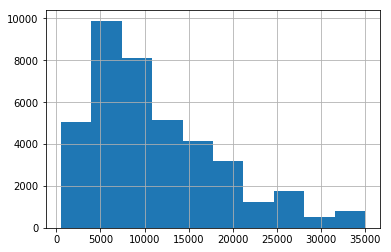

In [47]:
#Basic Histogram
df_final['loan_amnt'].hist()
plt.show()

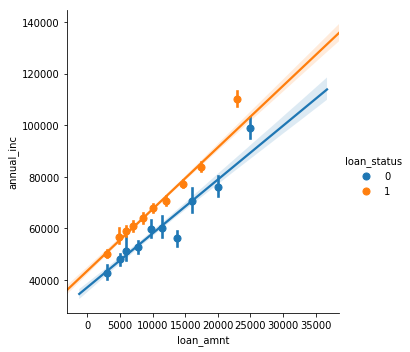

In [48]:
## A graph showing relationship between annual income vs. Paid off v. Charged Off. 
## Here we can see a clear relationship that higher income does lead to better chance of paying off your loan but, that is expected
sns.lmplot(x = 'loan_amnt', y = 'annual_inc', data = df_final, fit_reg = True, hue = 'loan_status', x_bins = 10)
plt.show()

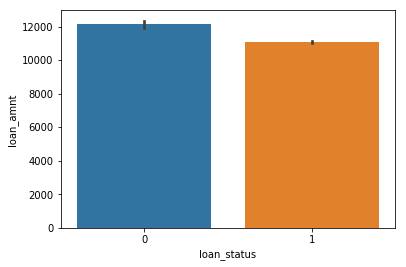

In [49]:
# 0 is Charge Off , 1 = Fully Paid 

sns.barplot(x = 'loan_status', y = 'loan_amnt', data = df_final)
plt.show()

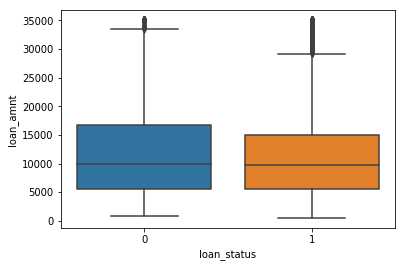

In [50]:
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = df_final)
plt.show()

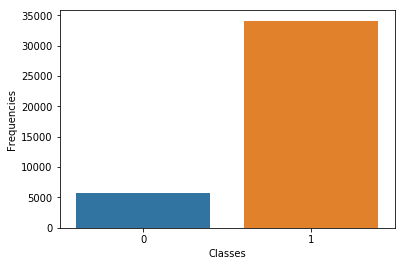

In [51]:
sns.countplot(x = 'loan_status', data = df_final)
plt.xlabel("Classes")
plt.ylabel("Frequencies")
plt.show()

In [52]:
corr = df_final[['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            'last_pymnt_amnt', 'loan_amnt', 'int_rate', 'open_acc',
            'loan_status']].corr()

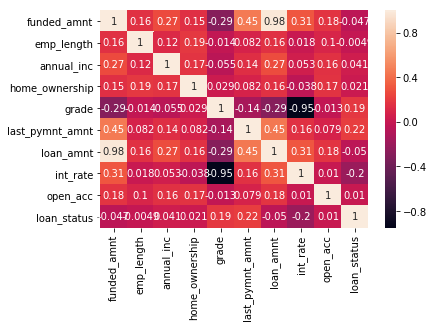

In [53]:
sns.heatmap(corr, annot = True)
plt.show()

In [54]:
df_final.corr()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,loan_amnt,int_rate,open_acc,loan_status
funded_amnt,1.000000,0.161981,0.267130,0.151106,-0.291942,0.453141,0.981544,0.313568,0.175515,-0.047299
emp_length,0.161981,1.000000,0.122358,0.187739,-0.014025,0.082401,0.162359,0.017656,0.101091,-0.004891
annual_inc,0.267130,0.122358,1.000000,0.174693,-0.055220,0.140584,0.271340,0.053485,0.158178,0.041168
home_ownership,0.151106,0.187739,0.174693,1.000000,0.029040,0.081680,0.155650,-0.037807,0.169069,0.021352
grade,-0.291942,-0.014025,-0.055220,0.029040,1.000000,-0.141104,-0.291485,-0.948674,-0.013337,0.191650
last_pymnt_amnt,0.453141,0.082401,0.140584,0.081680,-0.141104,1.000000,0.448642,0.157738,0.079063,0.215818
loan_amnt,0.981544,0.162359,0.271340,0.155650,-0.291485,0.448642,1.000000,0.310481,0.177216,-0.050035
int_rate,0.313568,0.017656,0.053485,-0.037807,-0.948674,0.157738,0.310481,1.000000,0.010311,-0.197918
open_acc,0.175515,0.101091,0.158178,0.169069,-0.013337,0.079063,0.177216,0.010311,1.000000,0.010199
loan_status,-0.047299,-0.004891,0.041168,0.021352,0.191650,0.215818,-0.050035,-0.197918,0.010199,1.000000


## __Principal Component Analysis:__

I did a Principal Component Analysis using 2 features to standarize the data as well as to understand impact of each feature in the dataset and compare it to the "loan_status" target. I also used PCA to visualize which shows a relationship between two classes and the two features generated by PCA.

I then did a Train Test split of the dataset to get it ready for supervised learning

In [55]:
x = df_final.loc[:, features].values
y = df_final.loc[:, ['loan_status']].values

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = StandardScaler().fit_transform(x)

In [57]:
pd.DataFrame(data = x, columns = features).head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,loan_amnt,int_rate,open_acc,loan_status
0,-0.828292,1.457108,-0.705423,-0.572992,0.417449,-0.564321,-0.834805,-0.369659,-1.430479,0.407673
1,-1.175805,-1.142258,-0.611323,-0.572992,-0.302911,-0.576015,-1.169726,0.869805,-1.430479,-2.452943
2,-1.189705,1.457108,-0.889671,-0.572992,-0.302911,-0.456679,-1.183123,1.054919,-1.657755,0.407673
3,-0.133267,1.457108,-0.310202,-0.572992,-0.302911,-0.522492,-0.164963,0.392262,0.160451,0.407673
4,-1.106302,-1.142258,0.172845,-0.572992,0.417449,-0.587799,-1.102742,0.177637,1.296830,0.407673


In [58]:
pca = PCA(n_components = 2)

In [59]:
principalComponents = pca.fit_transform(x)

In [60]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])

In [61]:
principalDf.head()

,PC 1,PC 2
0,-1.570055,-0.256103
1,-1.352790,-2.835946
2,-1.163599,-1.559294
3,0.003917,-0.293886
4,-1.423516,-0.333970


In [62]:
finalDf = pd.concat([principalDf, df_final[['loan_status']]], axis = 1)

In [63]:
finalDf.head()

,PC 1,PC 2,loan_status
0,-1.570055,-0.256103,1
1,-1.352790,-2.835946,0
2,-1.163599,-1.559294,1
3,0.003917,-0.293886,1
4,-1.423516,-0.333970,1


(-5, 6)

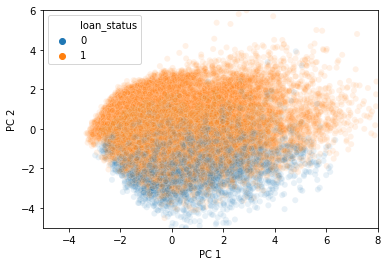

In [64]:
sns.scatterplot(x = 'PC 1', y = 'PC 2', data = finalDf, hue = 'loan_status', alpha = 0.1)
plt.xlim(-5, 8)
plt.ylim(-5, 6)

In [65]:
pca.explained_variance_ratio_

array([0.29566407, 0.17807643])

In [66]:
xt = x.T 
Cx = np.cov(xt)
print('Covariance Matrix: \n', Cx)

Covariance Matrix: 
 [[ 1.00002514  0.16198472  0.26713632  0.15111011 -0.29194929  0.45315287
   0.9815687   0.31357616  0.17551925 -0.04729997]
 [ 0.16198472  1.00002514  0.12236077  0.18774362 -0.01402559  0.0824028
   0.16236349  0.01765684  0.10109323 -0.00489105]
 [ 0.26713632  0.12236077  1.00002514  0.17469712 -0.05522166  0.14058765
   0.27134636  0.05348673  0.15818163  0.04116895]
 [ 0.15111011  0.18774362  0.17469712  1.00002514  0.02904058  0.08168231
   0.15565403 -0.03780786  0.16907279  0.02135241]
 [-0.29194929 -0.01402559 -0.05522166  0.02904058  1.00002514 -0.14110715
  -0.29149241 -0.94869763 -0.01333715  0.19165444]
 [ 0.45315287  0.0824028   0.14058765  0.08168231 -0.14110715  1.00002514
   0.44865339  0.15774159  0.07906465  0.21582379]
 [ 0.9815687   0.16236349  0.27134636  0.15565403 -0.29149241  0.44865339
   1.00002514  0.31048842  0.17722093 -0.05003607]
 [ 0.31357616  0.01765684  0.05348673 -0.03780786 -0.94869763  0.15774159
   0.31048842  1.00002514  0.01

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df_final.iloc[:,:-1], df_final.iloc[:,-1], test_size=0.2, random_state=42)

In [68]:
from sklearn.decomposition import PCA 
pca = PCA(n_components= 9, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [9.64772549e-01 3.03970909e-02 4.53853397e-03 2.91812637e-04
 5.60556476e-09 4.24310338e-09 3.44238553e-09 1.09998604e-10
 5.15072604e-11]


In [69]:
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
df_final = df_final[features]
print(X_train.shape)
print(df_final.shape)

(31828, 9)
(39786, 10)


## __Supervised Learning:__

## __Naive Bayes:__

This is just a simple model to see if it can accurately predict if a loan is fully paid vs. charged off. This model was chosen because of the simplicity purposes before moving on to more complex models that follow. First, I looked at a single variable and then I fit the train set / generated an accuracy score out of the test set.

- Accuracy score: 0.8613

Due to class imbalance, recall / precision for the minority class is really poor.

In [70]:
#Looking at Model Accuracy with only one variable here 

data = df_final['loan_amnt'].values.reshape(-1,1)
target = df_final['loan_status']
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(data, target)
y_pred = bnb.predict(data)
print('The accuracy score is: ', bnb.score(data, target))

The accuracy score is:  0.8574875584376414


In [71]:
# Looking at Model Accurancy with all features above
model = BernoulliNB().fit(X_train, y_train)
print(model.score(X_train, y_train))
predicted = model.predict(X_test)
print('Accuracy score is:', np.mean(predicted == y_test))

0.8586150559256001
Accuracy score is: 0.8613973360140739


In [72]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predicted))  
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

[[   7 1103]
 [   0 6848]]
With 20% Holdout: 0.8613973360140739
Testing on Sample: 0.8574875584376414


In [73]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1110
           1       0.86      1.00      0.93      6848

   micro avg       0.86      0.86      0.86      7958
   macro avg       0.93      0.50      0.47      7958
weighted avg       0.88      0.86      0.80      7958



In [74]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.85750188, 0.85750188, 0.85750188, 0.85750188, 0.85750188,
       0.85750188, 0.85746606, 0.85746606, 0.85746606, 0.85746606])

## __Random Forest Model & Random Forest Classifier using GridSearch:__

Second, I used the Random Forest Model specifically the RandomForestClassifier. This was used as it is helpful in classification models where there is a clear class imbalance like this dataset. It also helps reduce bias based on a single feature importance which I discovered this dataset to have.

- Accuracy Score: 0.8571

Due to class imbalance, precision / recall scores for the minority class is really poor.

Cross validation was used to see any overfitting which was not the case based on the scores.

In [75]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn import metrics

In [76]:
model = RandomForestClassifier(n_estimators = 1000, max_depth = 2) 
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8567299233379414
0.8605177180196029


In [77]:
#prediction related to model
#precision -- of all the prediction of 0 - how many actual
#recall - of all the def, how many were you able to identiy
print(metrics.classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1110
           1       0.86      1.00      0.93      6848

   micro avg       0.86      0.86      0.86      7958
   macro avg       0.43      0.50      0.46      7958
weighted avg       0.74      0.86      0.80      7958



In [78]:
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [1, 10, 100, 500, 1000, 1500], #optimal set of parameters in the internal range of parameters
               'max_depth': [1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = model, 
                          param_grid = parameters, 
                          scoring = 'accuracy',
                          cv = 10,
                          n_jobs = -1)
%time grid_search = grid_search.fit(X_train, y_train)

Wall time: 13min 13s


In [79]:
print(metrics.classification_report(y_test, predicted))
print(grid_search.score(X_test, y_test))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1110
           1       0.86      1.00      0.93      6848

   micro avg       0.86      0.86      0.86      7958
   macro avg       0.93      0.50      0.47      7958
weighted avg       0.88      0.86      0.80      7958

0.8766021613470721


In [80]:
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.93      7958

   micro avg       0.86      0.86      0.86      7958
   macro avg       0.50      0.43      0.46      7958
weighted avg       1.00      0.86      0.93      7958



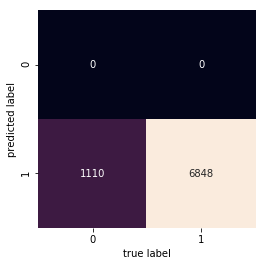

In [81]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [82]:
rfc = RandomForestClassifier(max_depth = 3)
X = df_final.drop('loan_status', 1)
Y = df_final['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis = 1)
rfc_cv = cross_val_score(rfc, X, Y, cv = 10)
rfc.fit(X, Y)
print(rfc.score(X, Y))
print(cross_val_score(rfc, X, Y, cv = 10))

0.8575126929070528
[0.85750188 0.85750188 0.85750188 0.85750188 0.85750188 0.85750188
 0.85746606 0.85746606 0.85721468 0.85746606]


In [83]:
rfc_cv.mean()

0.8574875562767879

In [84]:
rfc = RandomForestClassifier(max_depth = 3)
rfc.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
prediction = rfc.predict(X_test)

In [86]:
rf = RandomForestClassifier(criterion = 'gini', random_state = 0)
maxFeatures = range(1, df_final.shape[1]-1)
param_dist = dict(max_features = maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv = 10, scoring = 'accuracy', n_iter = len(maxFeatures), random_state = 10)
X = df_final.drop('loan_status' , 1)
Y = df_final['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis = 1)
rand.fit(X, Y)
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [87]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1]
rfAccuracy = accuracy_score(y_test,rfPredict)
print(rfAccuracy)

0.8719527519477256


__Feature Importance Generated using Random Forest Classifier:__

The most important feature appears to be Last Payment Amount which seems intuitive as someone who makes a payment or not leads to them paying fully vs. defaulting.

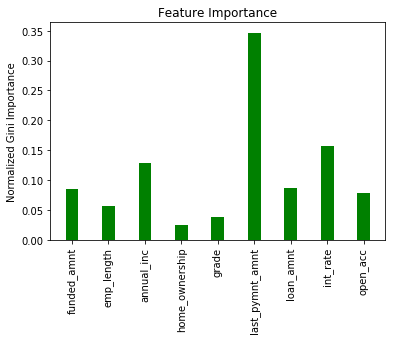

In [88]:
fig, ax = plt.subplots()
width = 0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color = 'g')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance')
ax.set_ylabel('Normalized Gini Importance')
plt.show()

## __Logistic Regression using GridSearch:__

Third model I used was Logistic Regression. To do so, I initially did a Logistic Regression using C values of 100 and then did a Grid Search to look for the ideal C Value parameter.

- Accuracy score: 0.8602

The precision and recall are still low for the minority class due to class imbalance

In [89]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 100)
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))

[[-6.28788872e-06  1.88036811e-04  1.69563719e-05  2.55119781e-04
   5.53109821e-04  2.34011349e-03 -6.86632709e-05  1.74242131e-04
   4.38432644e-04]]
0.8598894194521236
0.8568870177202463


In [90]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
parameters = [{'C': [1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = lr, 
                          param_grid = parameters, 
                          scoring = 'accuracy',
                          cv = 10,
                          n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.score(X_test, y_test))
%time grid_search = grid_search.fit(X_train, y_train)

0.8659210856999247
Wall time: 2.62 s


In [91]:
print(grid_search.best_params_)

{'C': 1000}


In [92]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
parameters = [{'C': [1, 10, 40, 70, 100, 200, 300, 400, 500, 600, 700, 800]}]
grid_search = GridSearchCV(estimator = lr, 
                          param_grid = parameters, 
                          scoring = 'accuracy',
                          cv = 10,
                          n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.score(X_test, y_test))

0.8602663985926112


In [93]:
print(grid_search.best_params_)

{'C': 500}


In [94]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()
parameters = [{'C': [1, 10, 30, 40, 50, 60, 70, 100, 110, 120, 130, 140]}]
grid_search = GridSearchCV(estimator = lr, 
                          param_grid = parameters, 
                          scoring = 'accuracy',
                          cv = 10,
                          n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.score(X_test, y_test))

0.8602663985926112


In [95]:
predicted = grid_search.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.49      0.07      0.13      1110
           1       0.87      0.99      0.92      6848

   micro avg       0.86      0.86      0.86      7958
   macro avg       0.68      0.53      0.52      7958
weighted avg       0.82      0.86      0.81      7958



## __SVM Model using GridSearch:__

I attempted to run SVM as it would help demonstrate distinction between the two classes clearly once a hyperplane is found. The code for this took too long but, I have included the GridSearch / SVM code here for reference.

In [96]:
#from sklearn.svm import SVC  ## takes super long to run..
#model = SVC(kernel = 'linear', C = 1e10)
#model.fit(X_train, y_train)
#model.score(X_train, y_train)

In [97]:
#model.support_vectors_

In [98]:
#paramaters = {'svc__C': [1], 
 #             'svc__gamma': [0.0001]}
#grid = GridSearchCV(model, parameters)

#%time grid.fit(X_train, y_train)
#print(grid.best_params_)

In [99]:
#model = grid.best_estimator_
#yfit = model.predict(X_test)
#model.score(X_test, y_test)

## __KNN Neighbors:__

Final model I used was the KNN Neighbors as it will predict classification of a new sample point based on the dataset. I initially started with just one n_neighbors parameter but then did a GridSearch expanding that to come up with the best accuracy score for the model.

- Accuracy Score: .8584

In [100]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))
print(knn.score(X_train, y_train))

0.8071123397838653
1.0


In [101]:
knn = KNeighborsClassifier()
k_range = list(range(10, 20))
parameters = dict(n_neighbors = k_range)
grid = GridSearchCV(knn, parameters, cv = 10, scoring = 'accuracy')
grid_search = grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid_search.score(X_train, y_train))
print(grid_search.score(X_test, y_test))

{'n_neighbors': 19}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=19, p=2,
           weights='uniform')
0.8609086339072515
0.8581301834631817


In [102]:
knn_pred = grid.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print(knn_acc)

0.8581301834631817


In [103]:
print(metrics.classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.43      0.05      0.09      1110
           1       0.87      0.99      0.92      6848

   micro avg       0.86      0.86      0.86      7958
   macro avg       0.65      0.52      0.51      7958
weighted avg       0.80      0.86      0.81      7958

